## [Sklearn POC] Diabetes Prediction using the Pima Indians Database 

#### The goal of this notebook is to predict whether a patient has Diabetes based on the Pima Indians database. Hence, the goal is to perform **binary classification** using different **Classification** algorithms, compare the performance of the different models and selecting the best model.

#### It also serves as a proof of concept of the **sklearn** library, so **the focus is on using preprocessing techniques, learning algorithms and evalutaion techniques only from this library**.



### Dataset introduction: Pima Indians Database

**Source**: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data

**Context**: This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Data Description**: The datasets consists of several medical predictor variables and one target variable, **Outcome**.
- Pregnancies: Number of pregnancies.
- Glucose: Plasma glucose concentration.
- BloodPressure: Diastolic blood pressure.
- SkinThickness: Triceps skinfold thickness.
- Insulin: 2-Hour serum insulin.
- BMI: Body mass index.
- DiabetesPedigreeFunction: Diabetes pedigree function score.
- Age: Age of the patient.
- Outcome: Target variable (0 for non-diabetic, 1 for diabetic).



### 1. Import the necessary libraries

Start by importing all the libraries necessary

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

### 2. Loading the dataset
The dataset downloaded from kaggle is in the csv format. We can make use of the read_csv function from the pandas library to load this dataset. A small sample of the dataset is also displayed below.

In [43]:
dataset = pd.read_csv("../data/diabetes.csv")
print(f"The dataset has {dataset.shape[0]} instances and {dataset.shape[1]} features")
dataset.head(10)

The dataset has 768 instances and 9 features


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


### 3. Data Analysis and Preprocessing 

#### 3.1 Data type check

Before we can do any preprocessing, let's check for the data types of each columns. Depending on the data types, we may have to apply different preprocessing techniques on the columns. Numerical and Categorical columns are usually handled differently

In [44]:
dataset.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

All of the columns in this dataset are **numerical (int or float)**. This can also be verified by looking at the small sample that we displayed above. We do not have any categorical columns except the target columns but even this can be left as it is.

#### 3.2 Missing values check
Missing values in the dataset need to be handled appropiately using suitable **imputation techniques** depending on the datatypes of the columns. 

In [45]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

None of the columns have missing values. This is usually a postive sign but let's dive deeper and check if values really make sense.

#### 3.3 Data distribution check

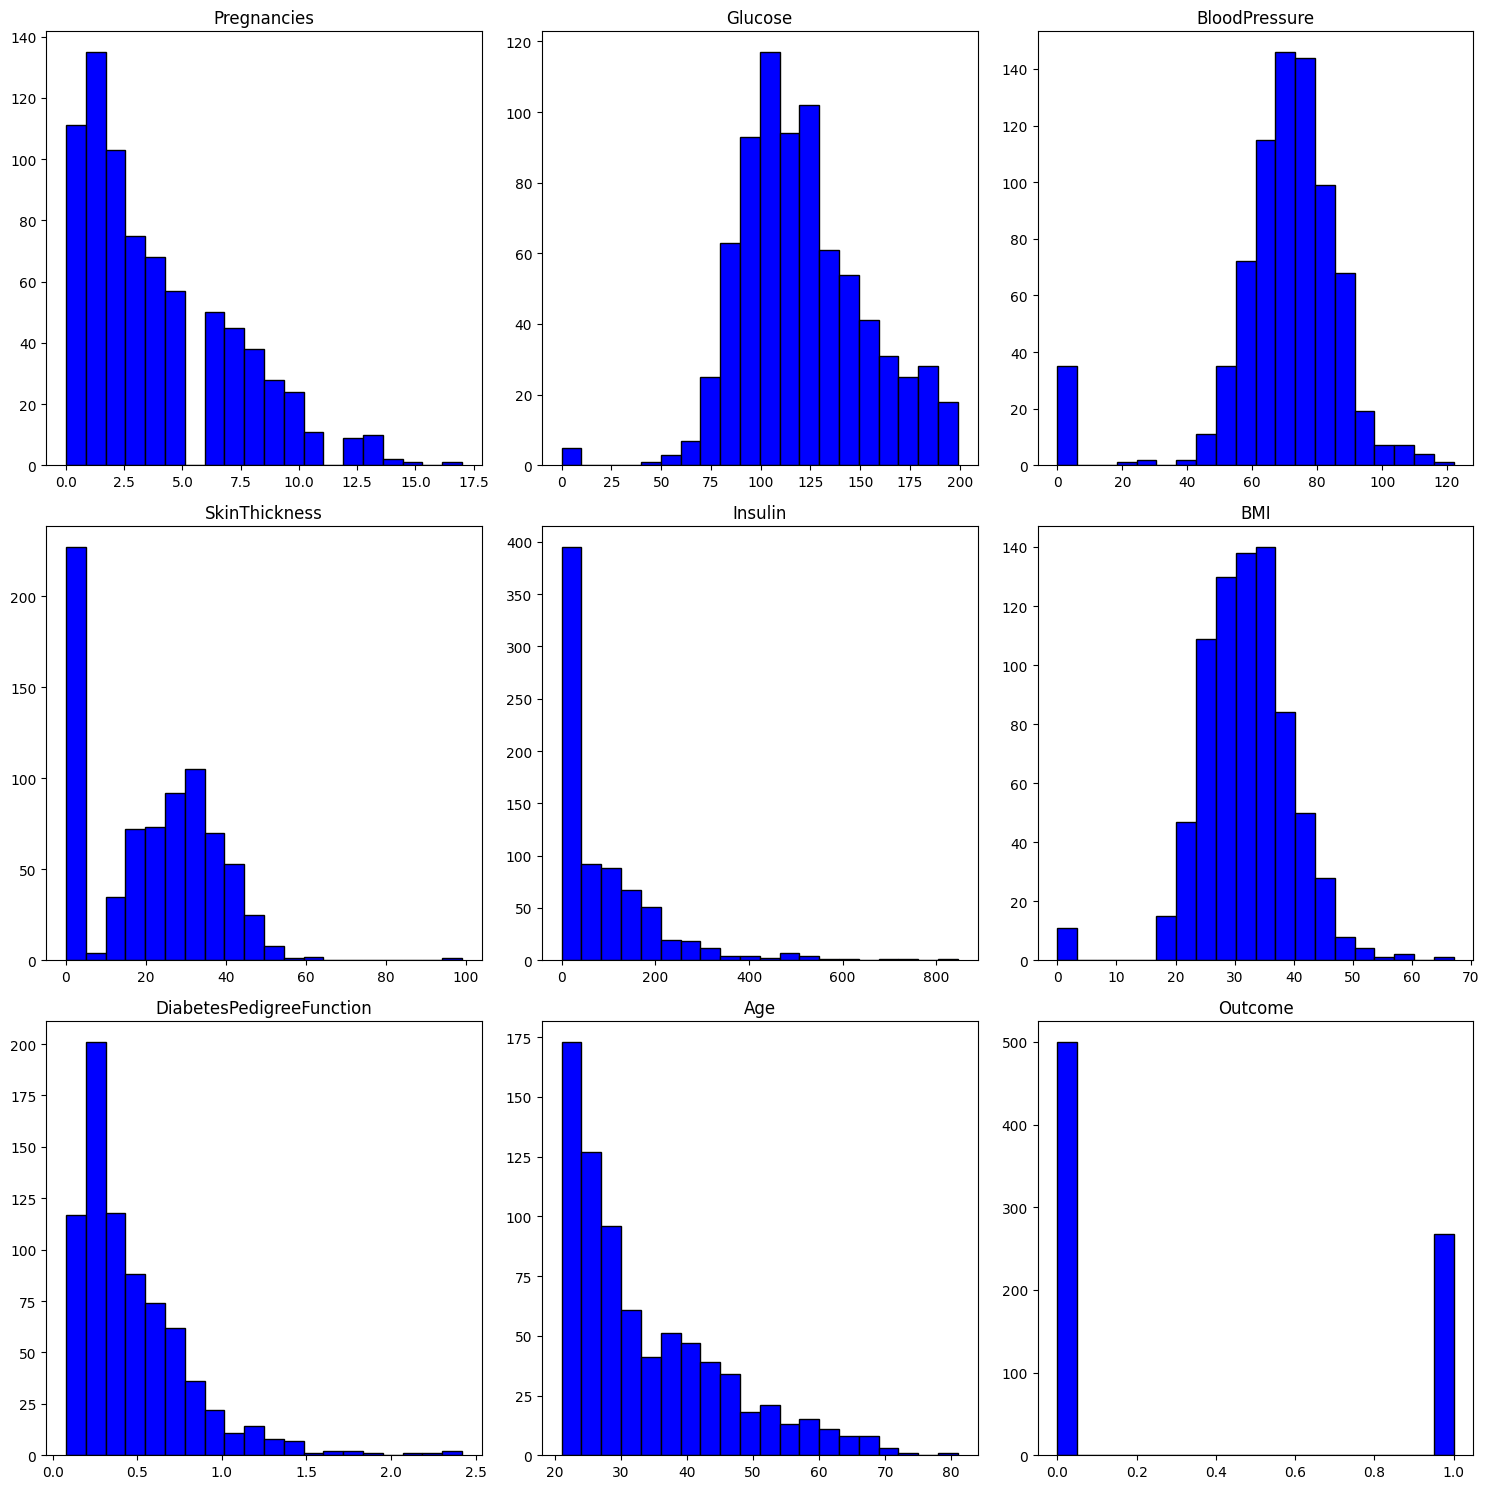

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(dataset.columns):
    axes[i].hist(dataset[col], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(col)

plt.tight_layout()

By looking at the distributions, it can be seen that Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin and BMI columns might have 0 values. Let's verify this by using the describe function.

In [47]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin and BMI columns have a min value of 0. 
Let's explore these "zero" values futher by listing out the count of "zero" values for each column. 

In [48]:
for column in dataset.columns:
    print(f'{column}: {dataset[column][dataset[column] == 0].count()} missing values')

Pregnancies: 111 missing values
Glucose: 5 missing values
BloodPressure: 35 missing values
SkinThickness: 227 missing values
Insulin: 374 missing values
BMI: 11 missing values
DiabetesPedigreeFunction: 0 missing values
Age: 0 missing values
Outcome: 500 missing values


A min value of 0 for pregnancies makes sense for obvious reasons. Not every person needs to have a history of pregnancies.
Age and DiabetesPedigreeFunction do not have missing values.
Outcome can have 0 values as this indicates the absence of Diabetes. We leave this column untouched.

For columns Glucose, BloodPressure, SkinThickness, Insulin and BMI, a zero value is problematic and we assume that these values were missing and were imputed with zeros when the dataset was released.

We need to find a better way to impute these "missing" value. The approach followed in this notebook is to **impute these values with the median value** of the column.

#### 3.4 Imputing missing values and data distribution check

Sklearn provides a **SimpleImputer** class to perform what we intend to achieve here. Hence we fit the imputer and transform only those columns that we consider as problematic.

In [49]:
dataset_cleaned = dataset.copy()
impute_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in impute_columns:
        imp_0 = SimpleImputer(missing_values=0, strategy='median')
        new_values = imp_0.fit_transform(dataset_cleaned.loc[dataset_cleaned["Outcome"] == 0, [col]])
        dataset_cleaned.loc[dataset_cleaned["Outcome"] == 0, col] = new_values.astype(dataset_cleaned[col].dtype)
        
        imp_1 = SimpleImputer(missing_values=0, strategy='median')
        new_values = imp_1.fit_transform(dataset_cleaned.loc[dataset_cleaned["Outcome"] == 1, [col]])
        dataset_cleaned.loc[dataset_cleaned["Outcome"] == 1, col] = new_values.astype(dataset_cleaned[col].dtype)


dataset_cleaned.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,169,33.6,0.627,50,1
1,1,85,66,29,102,26.6,0.351,31,0
2,8,183,64,32,169,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


After the imputation is performed, let's verify that those columns no longer contain "zero" values

In [50]:
for column in impute_columns:
    print(f'{column}: {dataset_cleaned[column][dataset_cleaned[column] == 0].count()} missing values')

Glucose: 0 missing values
BloodPressure: 0 missing values
SkinThickness: 0 missing values
Insulin: 0 missing values
BMI: 0 missing values


Let's plot the data distribution of all variable to see what it looks like after the imputation has been performed.

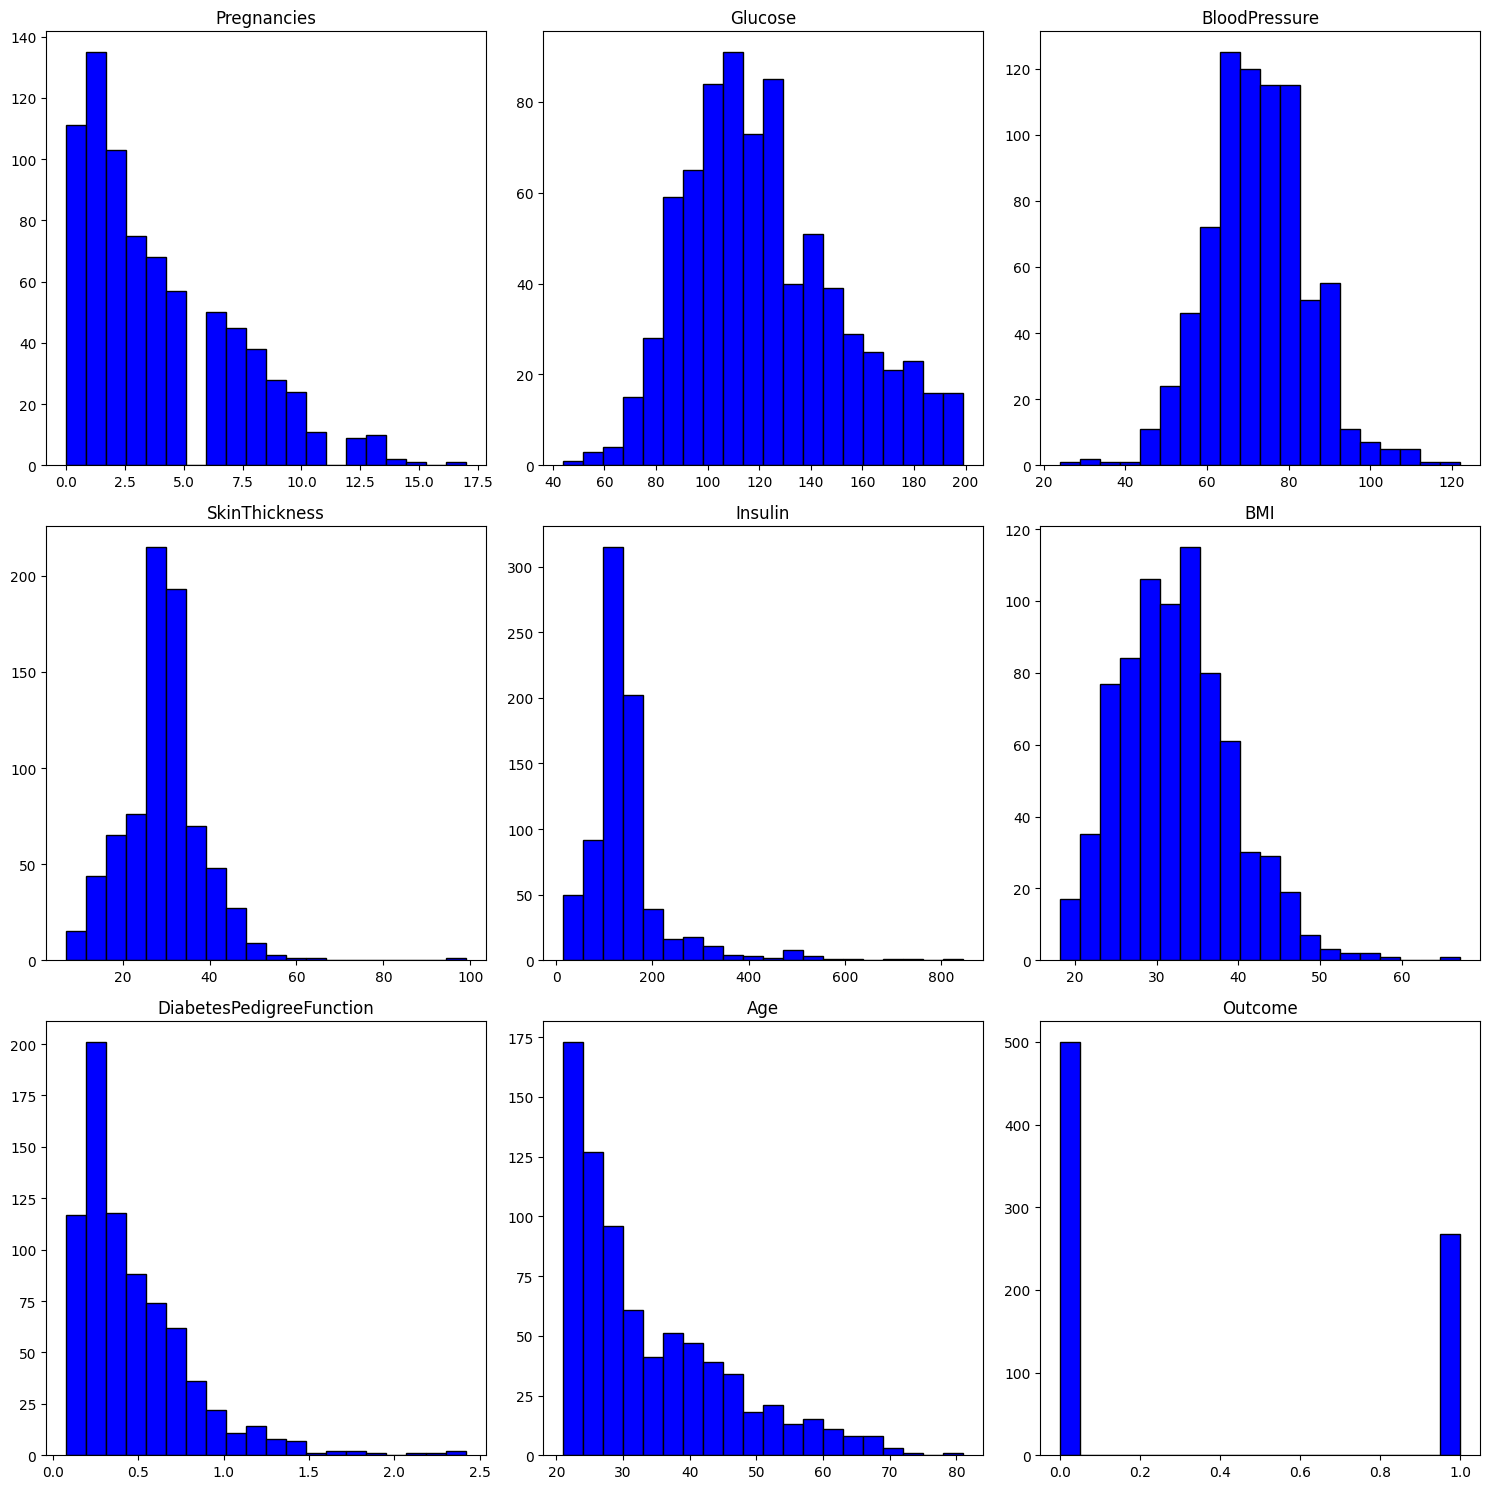

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(dataset_cleaned.columns):
    axes[i].hist(dataset_cleaned[col], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(col)

plt.tight_layout()

Most of these distributions are **not perfectly normal** and seem to be **skewed**. Notice that we also have the **class imbalance problem**. Class 0 is more predominant in comparison with class 1.

#### 3.5 Correlation analysis

Correlation analysis can be useful in identifying useful features. 

1. Correlation between target and predictor variables: If there is a **strong correlation between a predictor variable and the target variable**, then it means that the **predictor variable is important** to make predictions.

2. Correlation between different predictor variables: If there is a **strong correlation between two predictor variables**, then it means that these variables are **redundant** and that **one of these can be possibly removed (using dimensionality reduction techniques)** without affecting the model performance significantly.

<Axes: >

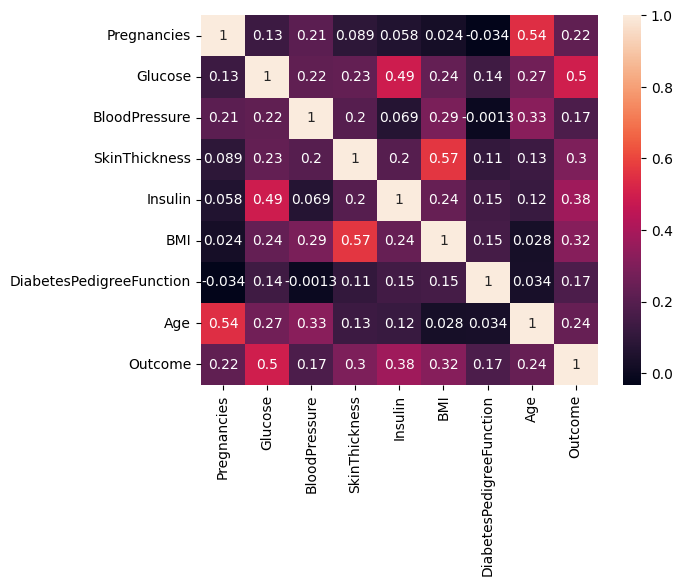

In [52]:
correlation_matrix = dataset_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True)

There seems to exist some positive correlation between (Pregnencies, Age), (Glucose, Outcome) and (SkinThickness, BMI). 

1. Pregnencies and age could be redundant variables. As in, one of these could be removed.
2. SkinThickness and BMI could be redundant variables. As in, one of these could be removed. 
3. Glucose could be important in predicting the outcome.  

For points 1 and 2, we do not take any action in this case. The correlations aren't strong enough. If the models do not perform too well, then it might be worth to reduce the dimensionality of the problem by choosing to remove one variable from each point.

### 3.6 Fixing Class imbalance

In [53]:
X = dataset_cleaned.drop(columns=["Outcome"])
y = dataset_cleaned["Outcome"]

print(f"Total Samples: {X.shape[0]}")
print(f"Samples in class 0: {y.value_counts()[0]}")
print(f"Samples in class 1: {y.value_counts()[1]}")

Total Samples: 768
Samples in class 0: 500
Samples in class 1: 268


The dataset has 500 samples in class 0 and 268 samples in class 1. Hence, our dataset suffers from the **class imbalance** problem.


Class imbalance can be fixed in many ways **(Resampling, SMOTE, generating new samples (with GANs) etc)**.
The SMOTE technique from imblearn library is used in this notebook.

In [54]:
smote = SMOTE()
X_new, y_new = smote.fit_resample(X, y)

print(f"Samples after SMOTE: {X_new.shape[0]}")
print(f"Samples in class 0: {y_new.value_counts()[0]}")
print(f"Samples in class 1: {y_new.value_counts()[1]}")

Samples after SMOTE: 1000
Samples in class 0: 500
Samples in class 1: 500


After SMOTE, we can see that both classes are equally balanced. 

Now that the data preprocessing is complete, we can proceed further and train a machine learning model on the given dataset.

### 4. Training a classification model

In this section, we focus on training models based on various classification algorithms. **All these models are trained with the default parameter and hyperparameter values** that sklearn provides. **Hyperparameter tuning is the focus of some of the later sections**. Below are the algorithms that are tried in this sections:

1. Logistic Regression
2. Support Vector Machines
3. Nearest Neighbor
4. Naive Bayes
5. Decision Tree
6. Random Forest
7. Multi-Layer Perceptron

#### 4.1 Splitting the dataset into training and test splits

The dataset needs to be split into training and testing sets. The training set is used to train the model and the testing set is used to evaluate the performance of the model. The train_test_split fuction from sklearn can be used to split the dataset into train and test sets.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2)

print(f"Samples in training set: {X_train.shape[0]}")
print(f"Samples in test set: {X_test.shape[0]}")

Samples in training set: 800
Samples in test set: 200


#### 4.2 Normalization

Normalization brings feature values within a constrained range / scale. Without normalization, the features that tend to have larger values (age) might influence the model more than features that tend to have smaller values (pregnencies).

The MinMaxScaler from sklearn performs min max scaling and transform each feature so that the values lie between [0, 1].

In [56]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pd.DataFrame(X_train, columns=X_new.columns).head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.294118,0.616883,0.408163,0.304348,0.150421,0.212679,0.147934,0.083333
1,0.058824,0.383117,0.061224,0.336957,0.081829,0.513292,0.046646,0.200000
2,0.352941,0.792208,0.602041,0.445652,0.007220,0.526990,0.685280,0.200000
3,0.058824,0.454545,0.428571,0.315217,0.222623,0.406953,0.093736,0.000000
4,0.000000,0.798701,0.510204,0.271739,0.185319,0.288595,0.337161,0.150000


#### 4.3 Training a Logistic Regression model

In [57]:
trained_models = dict()
predictions = dict()
seed = 42

In [58]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train, y_train)
trained_models["logistic_regression"] = lr
predictions["logistic_regression"] = lr.predict(X_test)

#### 4.4 Training a SVM model 

In [59]:
svm_classifier = svm.SVC(random_state=seed)
svm_classifier.fit(X_train, y_train)
trained_models["svm"] = svm_classifier
predictions["svm"] = svm_classifier.predict(X_test)

#### 4.5 Training a Nearest Neighbor Classifier model 

In [60]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
trained_models["KNN"] = knc
predictions["KNN"] = knc.predict(X_test)

#### 4.6 Training a Naive Bayes model 

In [61]:
nb = GaussianNB()
nb.fit(X_train, y_train)
trained_models["naive_bayes"] = nb
predictions["naive_bayes"] = nb.predict(X_test)

#### 4.7 Training a Decision Tree model 

In [62]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)
trained_models["decision_tree"] = dt
predictions["decision_tree"] = dt.predict(X_test)

#### 4.8 Training a Random Forest model 

In [63]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
trained_models["random_forest"] = rf
predictions["random_forest"] = rf.predict(X_test)

#### 4.9 Training a Multi-Layer Perceptron

In [64]:
mlp = MLPClassifier(random_state=seed)
mlp.fit(X_train, y_train)
trained_models["multi_layer_perceptron"] = mlp
predictions["multi_layer_perceptron"] = mlp.predict(X_test)

g:\miniconda\envs\ml-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 5. (Base) Model Evaluation

The trained models and the predictions on the test set have been saved in the dictionaries trained_models and predictions. We can now move ahead to evaluating the performance of these models on the test set. 

**Recall** is considered the most important metric in this case. The goal is to make recall as high as possible. By doing so, we are **minimizing false negatives**. That is, we want to make sure that the chance that the model predicts **no diabetes for a patient that actually has diabetes is as low as possible**.

It is still worth looking at the other metrics (like **precision, accuracy** etc) during model evaluation. Sklearn provides a function (**classification_report**) that calculates all these metrics, hence we use it here.

In [65]:
for algo, preds in predictions.items():
    print(f"Classification Metrics for the {algo} model")
    print("_" * 60)
    metrics = classification_report(y_test, preds)
    print(metrics, end="\n\n\n")

Classification Metrics for the logistic_regression model
____________________________________________________________
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        99
           1       0.77      0.83      0.80       101

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



Classification Metrics for the svm model
____________________________________________________________
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        99
           1       0.75      0.88      0.81       101

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



Classification Metrics for the KNN model
____________________________________________________________
              precis

From the results of each of these classifiers, it can be seen that the **Random Forest model has the best performance (Acc = 88%, Precision = 88%, Recall = 87%)** in comparison with the other models trained. It makes sense as multiple weak learners (ensemble) are trained in random forest and then combined to give the final predictions. This is the model that we proceed with and try to improve further.

**Note:** a random seed was used when training the model to reproduce the same results everytime.

### 6. Hyperparameter tuning - An attempt to improve the best model so far

As mentioned previously, the models trained above used the default parameter and hypermeter values that sklearn provides. The values of these hyperparameters can have significant impact on the final performance of the model. **In this section, the focus is on tuning the values of these parameters to hopefully find a model that outperforms the baseline random forest model.**

Sklearn provides hypyerparameter tuning utilities like **GridSearchCV** and **RandomizedSearchCV**. The notebook uses RandomizedSearchCV. Instead of trying every possible combination of hyperparameters (as in GridSearch), RandomizedSearchCV selects a random subset of hyperparameter combinations, which can significantly reduce the computational cost and still provide good results.

In [66]:
rfc = RandomForestClassifier(random_state=42)

param_distributions = {
'n_estimators': range(10, 150), # no. of weak learners (trees) in the forest
'max_depth': range(10, 50), # max depth of each of the tress
'min_samples_split': range(2, 10), # minimum number of samples required to split an internal node.
'min_samples_leaf': range(1, 5), # minimum number of samples required to be at a leaf node.
'bootstrap': [True, False], # whether bootstrap samples are used when building trees
}

random_search = RandomizedSearchCV(rfc, param_distributions, n_iter=50, cv=5)
random_search.fit(X_train, y_train)
random_search.best_params_

{'n_estimators': 17,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 43,
 'bootstrap': False}

RandomizedSearchCV returns the best parameters values from all the combinations that it tried. Let's run a RandomForestClassifier on this set of parameter values to see how the model performs on the test set. 

In [67]:
rfc_best = RandomForestClassifier(n_estimators=26, min_samples_leaf=1, min_samples_split=2, max_depth=19, bootstrap=False, random_state=42)
rfc_best.fit(X_train, y_train)
predictions = rfc_best.predict(X_test)

metrics = classification_report(y_test, predictions)
print(metrics)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        99
           1       0.87      0.89      0.88       101

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



When using the parameters values returned by RandomizedSearchCV, there is a slight boost in performance of the model **(Acc = 90%, Precision = 90%, Recall = 89%)**

**There could be a better model, based on other combinations of hyperparameter values, as we did not try all possible combinations. But the model that we have at this stage is already a really solid one so we the search for a better model stops here.**

Further steps that can be tried out:
- try GridSearchCV to try out more possible combinations of hyperparameter values.
- try GridSearchCV / RandomizedSearchCV on the ANN model to see if we can achieve better performance. This is worth trying out neural networks can provide superior results.

It is also worth mentioning that the online ML community has achieved better results on this same dataset but many of those results are based on more complex algorithms like Neural Networks. As a part of this notebook, a simple ANN model was trained but the random forest model outperformed it (With default parameters), hence it is definitely possible to get a better model but as the focus of this notebook is to mainly use algorithms that come out of the box from sklearn, we end here!